<a href="https://colab.research.google.com/github/hyluuu/Airfoil-Noise-Regressor-Decision-Tree-/blob/main/Decision_Tree_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Base Decision Tree model

Hyperparameter tuning is defined here, however the gridsearch is not used to actually employ such a technique.

Mean Squared Error (MSE): 17.14


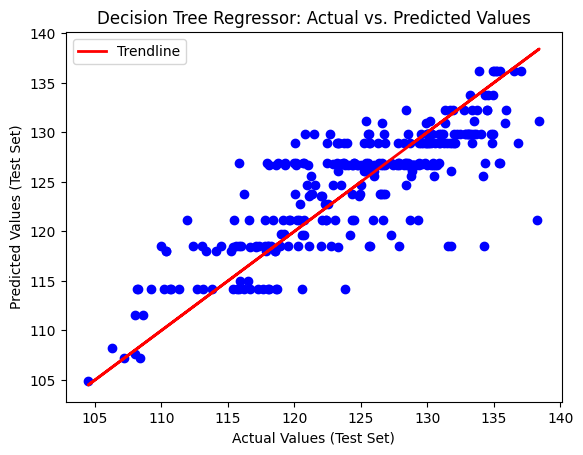

In [ ]:
# -------------- STEP 1: IMPORT NECESSARY LIBRARIES --------------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# -------------- STEP 2: LOAD NEW DATASET (airfoilnoise.csv) --------------
# Load the airfoil noise dataset from a CSV file
dataset_path = 'airfoilnoise.csv'
data = pd.read_csv(dataset_path)

# Extract features (first five columns) and the target variable (last column)
X = data.iloc[:, :-1].values  # Features are all columns except the last one
y = data.iloc[:, -1].values  # Target variable is the last column

# -------------- STEP 3: SPLIT DATA INTO TRAINING - VALIDATION - TESTING SETS --------------
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# -------------- STEP 4: DECISION TREE REGRESSOR CLASS IMPLEMENTATION WITHOUT HYPERPARAMETER SUPPORT --------------
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTreeRegressor:
    def __init__(self, min_samples_split=2, max_depth=5, min_samples_leaf=1):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.root = None

    def fit(self, X, y):
        dataset = np.column_stack((X, y))
        self.root = self._build_tree(dataset)

    def _build_tree(self, dataset, depth=0):
        X, y = dataset[:, :-1], dataset[:, -1]
        num_samples, num_features = X.shape

        if num_samples < self.min_samples_split or depth >= self.max_depth or num_samples < self.min_samples_leaf:
            leaf_value = np.mean(y)
            return Node(value=leaf_value)

        best_split = self._get_best_split(dataset, num_samples, num_features)

        if best_split is None:
            leaf_value = np.mean(y)
            return Node(value=leaf_value)

        left_subtree = self._build_tree(best_split["dataset_left"], depth + 1)
        right_subtree = self._build_tree(best_split["dataset_right"], depth + 1)
        return Node(best_split["feature_index"], best_split["threshold"], left_subtree, right_subtree)

    def _get_best_split(self, dataset, num_samples, num_features):
        best_split = {}
        max_var_red = -float("inf")

        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)

            for threshold in possible_thresholds:
                dataset_left, dataset_right = self._split(dataset, feature_index, threshold)

                # Ensure both left and right datasets have the minimum samples
                if (len(dataset_left) > 0 and len(dataset_right) > 0 and
                    len(dataset_left) >= self.min_samples_leaf and
                    len(dataset_right) >= self.min_samples_leaf):
                    y = dataset[:, -1]
                    left_y, right_y = dataset_left[:, -1], dataset_right[:, -1]
                    curr_var_red = self._variance_reduction(y, left_y, right_y)

                    if curr_var_red > max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        max_var_red = curr_var_red

        return best_split if max_var_red > 0 else None

    def _split(self, dataset, feature_index, threshold):
        dataset_left = dataset[dataset[:, feature_index] <= threshold]
        dataset_right = dataset[dataset[:, feature_index] > threshold]
        return dataset_left, dataset_right

    def _variance_reduction(self, parent, left_child, right_child):
        weight_l = len(left_child) / len(parent)
        weight_r = len(right_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(left_child) + weight_r * np.var(right_child))
        return reduction

    def predict(self, X):
        return [self._make_prediction(x, self.root) for x in X]

    def _make_prediction(self, x, tree):
        if tree.value is not None:
            return tree.value
        if x[tree.feature_index] <= tree.threshold:
            return self._make_prediction(x, tree.left)
        else:
            return self._make_prediction(x, tree.right)

    def print_tree(self, tree=None, indent=" "):
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)
        else:
            print(f"X_{tree.feature_index} <= {tree.threshold}?")
            print(f"{indent}left:", end="")
            self.print_tree(tree.left, indent + indent)
            print(f"{indent}right:", end="")
            self.print_tree(tree.right, indent + indent)

# -------------- STEP 5: PREDICTIONS AND EVALUATION --------------
# Initialize the DecisionTreeRegressor with specific parameters
regressor = DecisionTreeRegressor(min_samples_split=2, max_depth=5, min_samples_leaf=1)

# Fit the model on the training set
regressor.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = regressor.predict(X_test)

# Calculate the Mean Squared Error
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error (MSE): {test_mse:.2f}")

# Print the tree structure
#print("Decision Tree Structure:")
#regressor.print_tree()

# Create a scatter plot of actual vs. predicted values for the test set
plt.scatter(y_test, y_test_pred, color='blue')
plt.xlabel("Actual Values (Test Set)")
plt.ylabel("Predicted Values (Test Set)")
plt.title("Decision Tree Regressor: Actual vs. Predicted Values")

# Add the trendline (y = x)
plt.plot(y_test, y_test, color='red', linewidth=2, label='Trendline')
plt.legend()
plt.show()


# Hyperparameter Tuning

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'ccp_alpha': 0.28, 'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 4}
Testing Mean Squared Error (MSE) after tuning: 7.73


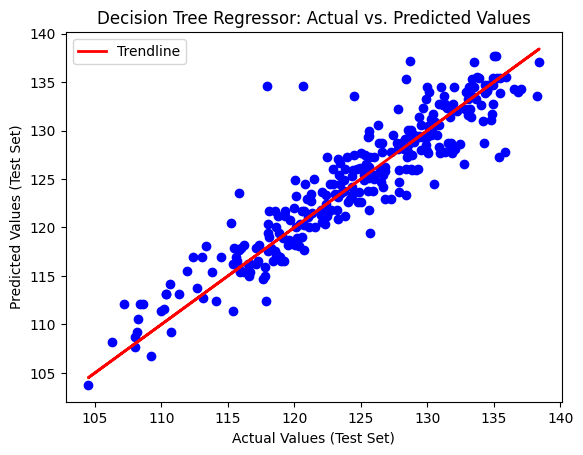

In [ ]:
# -------------- STEP 1: IMPORT NECESSARY LIBRARIES --------------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

# -------------- STEP 2: LOAD NEW DATASET (airfoilnoise.csv) --------------
# Load the airfoil noise dataset from a CSV file

dataset_path = 'airfoilnoise.csv'  # Update with your file path if necessary
data = pd.read_csv(dataset_path)

# Extract features (first five columns) and the target variable (last column)
X = data.iloc[:, :-1].values  # Features are all columns except the last one
y = data.iloc[:, -1].values  # Target variable is the last column

# -------------- STEP 3: SPLIT DATA INTO TRAINING - VALIDATION - TESTING SETS --------------
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# -------------- STEP 4: DECISION TREE REGRESSOR CLASS IMPLEMENTATION WITH HYPERPARAMETER SUPPORT --------------
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTreeRegressor:
    def __init__(self, min_samples_split=2, max_depth=5, min_samples_leaf=1, ccp_alpha=0.0):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.ccp_alpha = ccp_alpha
        self.root = None

    def fit(self, X, y):
        dataset = np.column_stack((X, y))
        self.root = self._build_tree(dataset)

    def _build_tree(self, dataset, depth=0):
        X, y = dataset[:, :-1], dataset[:, -1]
        num_samples, num_features = X.shape

        if num_samples < self.min_samples_split or depth >= self.max_depth or num_samples < self.min_samples_leaf:
            leaf_value = np.mean(y)
            return Node(value=leaf_value)

        best_split = self._get_best_split(dataset, num_samples, num_features)

        if best_split is None:
            leaf_value = np.mean(y)
            return Node(value=leaf_value)

        left_subtree = self._build_tree(best_split["dataset_left"], depth + 1)
        right_subtree = self._build_tree(best_split["dataset_right"], depth + 1)

        # Compute cost complexity pruning (SSE + alpha * number of nodes)
        left_sse = self._sse(best_split["dataset_left"][:, -1])
        right_sse = self._sse(best_split["dataset_right"][:, -1])
        current_sse = self._sse(y)

        # Prune based on ccp_alpha
        if current_sse - (left_sse + right_sse) < self.ccp_alpha:
            leaf_value = np.mean(y)
            return Node(value=leaf_value)

        return Node(best_split["feature_index"], best_split["threshold"], left_subtree, right_subtree)

    def _get_best_split(self, dataset, num_samples, num_features):
        best_split = {}
        max_var_red = -float("inf")

        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)

            for threshold in possible_thresholds:
                dataset_left, dataset_right = self._split(dataset, feature_index, threshold)

                if (len(dataset_left) > 0 and len(dataset_right) > 0 and
                    len(dataset_left) >= self.min_samples_leaf and
                    len(dataset_right) >= self.min_samples_leaf):
                    y = dataset[:, -1]
                    left_y, right_y = dataset_left[:, -1], dataset_right[:, -1]
                    curr_var_red = self._variance_reduction(y, left_y, right_y)

                    if curr_var_red > max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        max_var_red = curr_var_red

        return best_split if max_var_red > 0 else None

    def _split(self, dataset, feature_index, threshold):
        dataset_left = dataset[dataset[:, feature_index] <= threshold]
        dataset_right = dataset[dataset[:, feature_index] > threshold]
        return dataset_left, dataset_right

    def _variance_reduction(self, parent, left_child, right_child):
        weight_l = len(left_child) / len(parent)
        weight_r = len(right_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(left_child) + weight_r * np.var(right_child))
        return reduction

    def _sse(self, y):
        """Compute Sum of Squared Errors for a given set of target values."""
        return np.sum((y - np.mean(y)) ** 2)

    def predict(self, X):
        return [self._make_prediction(x, self.root) for x in X]

    def _make_prediction(self, x, tree):
        if tree.value is not None:
            return tree.value
        if x[tree.feature_index] <= tree.threshold:
            return self._make_prediction(x, tree.left)
        else:
            return self._make_prediction(x, tree.right)

    def get_params(self, deep=True):
        return {
            'min_samples_split': self.min_samples_split,
            'max_depth': self.max_depth,
            'min_samples_leaf': self.min_samples_leaf,
            'ccp_alpha': self.ccp_alpha
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


    def print_tree(self, tree=None, indent=" "):
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)
        else:
            print(f"X_{tree.feature_index} <= {tree.threshold}?")
            print(f"{indent}left:", end="")
            self.print_tree(tree.left, indent + indent)
            print(f"{indent}right:", end="")
            self.print_tree(tree.right, indent + indent)

# -------------- STEP 5: HYPERPARAMETER TUNING USING GRIDSEARCHCV --------------
# Define the parameter grid for tuning
param_grid = {
    'min_samples_split': [4, 5],
    'max_depth': [14, 15],
    'min_samples_leaf': [1, 2, 3],
    'ccp_alpha':[0.28, 0.29]
}

# Initialize the DecisionTreeRegressor
regressor = DecisionTreeRegressor()

# Create the GridSearchCV instance
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


# -------------- STEP 6: PREDICTIONS AND EVALUATION --------------
# Make predictions with the best pruned model
y_test_pred = best_model.predict(X_test)

# Calculate the Mean Squared Error
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Best Parameters: {best_params}")
print(f"Testing Mean Squared Error (MSE) after tuning: {test_mse:.2f}")

# Print the tree with the best parameters

#print("Decision Tree Structure with Best Parameters:")
#best_model.print_tree()

# Create a scatter plot of actual vs. predicted values for the test set
plt.scatter(y_test, y_test_pred, color='blue')
plt.xlabel("Actual Values (Test Set)")
plt.ylabel("Predicted Values (Test Set)")
plt.title("Decision Tree Regressor: Actual vs. Predicted Values")

# Add the trendline (y = x)
plt.plot(y_test, y_test, color='red', linewidth=2, label='Trendline')
plt.legend()
plt.show()

# Hyperparameter tuning + Cross Validation

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'ccp_alpha': 0.29, 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 4}
Testing Mean Squared Error (MSE) after tuning: 6.28


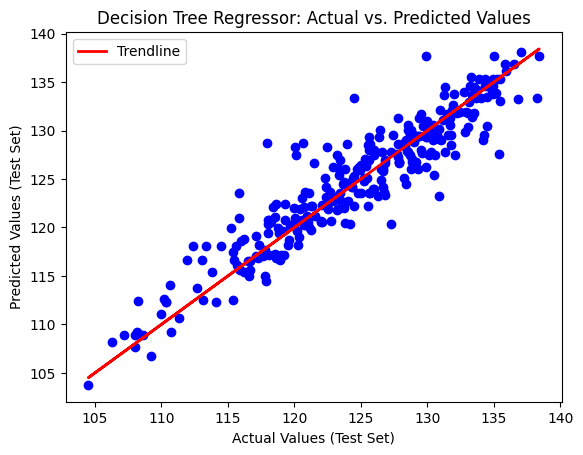

In [ ]:
# -------------- STEP 1: IMPORT NECESSARY LIBRARIES --------------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# -------------- STEP 2: LOAD NEW DATASET (airfoilnoise.csv) --------------
# Load the airfoil noise dataset from a CSV file
dataset_path = 'airfoilnoise.csv'  # Update with your file path if necessary
data = pd.read_csv(dataset_path)

# Extract features (first five columns) and the target variable (last column)
X = data.iloc[:, :-1].values  # Features are all columns except the last one
y = data.iloc[:, -1].values  # Target variable is the last column

# -------------- STEP 3: SPLIT DATA INTO TRAINING - VALIDATION - TESTING SETS --------------
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# -------------- STEP 4: DECISION TREE REGRESSOR CLASS IMPLEMENTATION WITH HYPERPARAMETER SUPPORT --------------
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTreeRegressor:
    def __init__(self, min_samples_split=2, max_depth=5, min_samples_leaf=1, ccp_alpha=0.0):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.ccp_alpha = ccp_alpha
        self.root = None

    def fit(self, X, y):
        dataset = np.column_stack((X, y))
        self.root = self._build_tree(dataset)

    def _build_tree(self, dataset, depth=0):
        X, y = dataset[:, :-1], dataset[:, -1]
        num_samples, num_features = X.shape

        if num_samples < self.min_samples_split or depth >= self.max_depth or num_samples < self.min_samples_leaf:
            leaf_value = np.mean(y)
            return Node(value=leaf_value)

        best_split = self._get_best_split(dataset, num_samples, num_features)

        if best_split is None:
            leaf_value = np.mean(y)
            return Node(value=leaf_value)

        left_subtree = self._build_tree(best_split["dataset_left"], depth + 1)
        right_subtree = self._build_tree(best_split["dataset_right"], depth + 1)

        left_sse = self._sse(best_split["dataset_left"][:, -1])
        right_sse = self._sse(best_split["dataset_right"][:, -1])
        current_sse = self._sse(y)

        if current_sse - (left_sse + right_sse) < self.ccp_alpha:
            leaf_value = np.mean(y)
            return Node(value=leaf_value)

        return Node(best_split["feature_index"], best_split["threshold"], left_subtree, right_subtree)

    def _get_best_split(self, dataset, num_samples, num_features):
        best_split = {}
        max_var_red = -float("inf")

        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)

            for threshold in possible_thresholds:
                dataset_left, dataset_right = self._split(dataset, feature_index, threshold)

                if (len(dataset_left) > 0 and len(dataset_right) > 0 and
                    len(dataset_left) >= self.min_samples_leaf and
                    len(dataset_right) >= self.min_samples_leaf):
                    y = dataset[:, -1]
                    left_y, right_y = dataset_left[:, -1], dataset_right[:, -1]
                    curr_var_red = self._variance_reduction(y, left_y, right_y)

                    if curr_var_red > max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        max_var_red = curr_var_red

        return best_split if max_var_red > 0 else None

    def _split(self, dataset, feature_index, threshold):
        dataset_left = dataset[dataset[:, feature_index] <= threshold]
        dataset_right = dataset[dataset[:, feature_index] > threshold]
        return dataset_left, dataset_right

    def _variance_reduction(self, parent, left_child, right_child):
        weight_l = len(left_child) / len(parent)
        weight_r = len(right_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(left_child) + weight_r * np.var(right_child))
        return reduction

    def _sse(self, y):
        """Compute Sum of Squared Errors for a given set of target values."""
        return np.sum((y - np.mean(y)) ** 2)

    def predict(self, X):
        return [self._make_prediction(x, self.root) for x in X]

    def _make_prediction(self, x, tree):
        if tree.value is not None:
            return tree.value
        if x[tree.feature_index] <= tree.threshold:
            return self._make_prediction(x, tree.left)
        else:
            return self._make_prediction(x, tree.right)

    def get_params(self, deep=True):
        return {
            'min_samples_split': self.min_samples_split,
            'max_depth': self.max_depth,
            'min_samples_leaf': self.min_samples_leaf,
            'ccp_alpha': self.ccp_alpha
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def print_tree(self, tree=None, indent=" "):
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)
        else:
            print(f"X_{tree.feature_index} <= {tree.threshold}?")
            print(f"{indent}left:", end="")
            self.print_tree(tree.left, indent + indent)
            print(f"{indent}right:", end="")
            self.print_tree(tree.right, indent + indent)

# -------------- STEP 5: HYPERPARAMETER TUNING USING GRIDSEARCHCV --------------
# Define the parameter grid for tuning
param_grid = {
    'min_samples_split': [4, 5],
    'max_depth': [14, 15],
    'min_samples_leaf': [1, 2],
    'ccp_alpha':[0.28, 0.29]
}

# Initialize the DecisionTreeRegressor
regressor = DecisionTreeRegressor()

# Create the GridSearchCV instance with cross-validation
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_train_val, y_train_val)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# -------------- STEP 6: PREDICTIONS AND EVALUATION --------------
# Make predictions with the best pruned model
y_test_pred = best_model.predict(X_test)

# Calculate the Mean Squared Error
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Best Parameters: {best_params}")
print(f"Testing Mean Squared Error (MSE) after tuning: {test_mse:.2f}")

# Print the tree with the best parameters
#print("Decision Tree Structure with Best Parameters:")
#best_model.print_tree()

# Create a scatter plot of actual vs. predicted values for the test set
plt.scatter(y_test, y_test_pred, color='blue')
plt.xlabel("Actual Values (Test Set)")
plt.ylabel("Predicted Values (Test Set)")
plt.title("Decision Tree Regressor: Actual vs. Predicted Values")

# Add the trendline (y = x)
plt.plot(y_test, y_test, color='red', linewidth=2, label='Trendline')
plt.legend()
plt.show()


# Results

1. Base model
2. Hyperparameter tuned model
3. Hyperparamter tuned + Cross validated model

Measured by Mean Squared Error (MSE, lower is better)

1: MSE = 17.14

2: MSE = 7.73

3: MSE = 6.28
